# Import

In [1]:
import torch
import torchaudio
import matplotlib.pyplot as plt
from torch.utils.data.dataset import Dataset
from torchaudio.datasets import VCTK_092

import numpy as np
from torch.utils.data import DataLoader, TensorDataset, Subset
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

from IPython.display import Audio
from IPython.display import display

# Cuda Manegement

In [2]:
torch.cuda.empty_cache()
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
print(f"Total Memory: {t}")
print(f"Reserved Memory: {r}")
print(f"Allocated Memory: {a}")
print(f"Free Memory: {f}")

Total Memory: 12779126784
Reserved Memory: 0
Allocated Memory: 0
Free Memory: 0


# Hyperparameters

In [3]:
BATCH_SIZE = 2
EPOCHS = 15
WAVE_LENGTH = 81920#40960
LEARNING_RATE = 0.001
SPLIT = 0.5

np.random.seed(0)

# Utility Methods

In [4]:
#compute number of paramters of a model
def nparams(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

#get if cuda is available
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

#plot of a waveform eventually in a standard (-1,1) range
def plot_waveform(waveform, sample_rate, limit=False):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if limit:
        axes.set_ylim(-1, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")

#method to save the results of the model (plots and audio files)
def save_results(model, dl, nfiles=100):
    with torch.no_grad():
        model.eval()
        i = 0
        device = get_device()
        for waveform, sample_rate, _ in dl:
            waveform = waveform.float().to(device)
            logits, _ = model(waveform)

            for j in range(len(logits)):
                plot_waveform(logits[j].detach().cpu(), sample_rate[j])
                plt.savefig("audio_plots/val/reconstructed/rec_" + str(i) + ".png")
                plt.close()

                plot_waveform(waveform[j].detach().cpu(), sample_rate[j])
                plt.savefig("audio_plots/val/original/ori_" + str(i) + ".png")
                plt.close()

                torchaudio.save("audio_files/val/reconstructed/rec_" + str(i) + ".wav", logits[j].detach().cpu(), sample_rate[j])
                torchaudio.save("audio_files/val/original/ori_" + str(i) + ".wav", waveform[j].detach().cpu(), sample_rate[j])
                i += 1
            if i >= nfiles:
                break

# Dataset Class for deal with audio tracks

In [8]:
#this class has to handle the fact that the input tracks have different lengths (while the sample rate is the same in VCTK)
class EqualDataset(Dataset):
    def __init__(self, dataset, wave_length):
        self.data = dataset
        self.wave_length = wave_length

    def __getitem__(self, index):
        waveform, sample_rate, _, speaker_id, _ = self.data[index]
        wave_length = waveform.shape[1]
        #if the waveform is longer than the desired length, it is randomly cut to match the desired length
        if wave_length > self.wave_length:
            waveform = self._random_cut_(waveform, wave_length)
        #if the waveform is shorter than the desired length, it is padded with zeros to match the desired length
        elif wave_length < self.wave_length:
            waveform = torch.cat([waveform, torch.zeros(1, self.wave_length - wave_length)], dim=1)
        return waveform, sample_rate, speaker_id

    def __len__(self):
        return len(self.data)
    
    def _random_cut_(self, w, wl):
        start = np.random.randint(0,wl - self.wave_length, (1,)).item()
        wave = w[:, start:start+self.wave_length]
        return wave

# Trainer Class for training, saving and plotting results

In [10]:
class Trainer:
    def __init__(self, device, model, opt, path=None):
        self.device = device
        self.model = model
        self.model.to(self.device)
        self.opt = opt
        self.loss_train = []
        self.loss_test = []
        self.abs_mean_train = []
        self.abs_mean_test = []
        self.epochs = 0
        if path:
            self.model.load_state_dict(torch.load(path))
            
    def train(self, epochs, dl_train, dl_test=None, check=100, save=False):
        self.model.train()
        self.loss_train = []
        self.loss_test = []
        self.abs_mean_train = []
        self.abs_mean_test = []
        for i in range(self.epochs+1,self.epochs+epochs+1):
            avg_loss_train, abs_mean_tr = self._train_epoch_(dl_train, i)
            self.abs_mean_train.append(abs_mean_tr)
            self.loss_train.append(avg_loss_train)
            if i%check==0 and i !=0:
                print(f"Epoch {i} -> Train Loss: {avg_loss_train}, Mean Absolute Error: {abs_mean_tr}")
                if save:
                    model_string = self.model.name + ".pt"
                    path = "./models/" + model_string
                    torch.save(self.model.state_dict(), path)
            if dl_test:
                avg_loss_test, abs_mean_te = self._test_epoch_(dl_test, i)
                self.loss_test.append(avg_loss_test)
                self.abs_mean_test.append(abs_mean_te)
                if i%check==0 and i !=0:
                    print(f"Epoch {i} -> Test Loss: {avg_loss_test}, Mean Absolute Error: {abs_mean_te}")

            self.epochs += 1
        self._plot_()

    #method to get the indexes codes as a dataset for the autoregressuve model fitting and may generate
    def get_index_dataset(self, dl_train):
        with torch.no_grad():
            idx = torch.tensor([])
            for waveform, _, _ in tqdm(dl_train, desc=f'Getting Indexes', leave = False):
                waveform = waveform.float().to(self.device)
                min_idx = self.model.get_vq_indexes(waveform)
                idx = torch.cat([idx, min_idx.cpu()])
            return idx
    
    def _train_epoch_(self, dl_train, epoch):
        epoch_loss = 0
        for waveform, _, _ in tqdm(dl_train, desc=f'Training epoch {epoch}', leave = False):
            waveform = waveform.float().to(self.device)
            logits, vq_loss = self.model(waveform)
            total_loss = F.mse_loss(logits, waveform) + vq_loss
            abs_mean = torch.mean(torch.abs(logits - waveform)).item()

            self.opt.zero_grad()
            total_loss.backward()
            self.opt.step()
            epoch_loss += total_loss.item()
        return epoch_loss / len(dl_train), abs_mean
    
    def _test_epoch_(self, dl_test, epoch):
        epoch_loss = 0
        with torch.no_grad():
            for waveform, _, _ in tqdm(dl_test, desc=f'Testing epoch {epoch}', leave = False):
                waveform = waveform.float().to(self.device)
                logits, vq_loss = self.model(waveform)
                total_loss = F.mse_loss(logits, waveform) + vq_loss
                epoch_loss += total_loss.item()
                abs_mean = torch.mean(torch.abs(logits - waveform)).item()
            return epoch_loss / len(dl_test), abs_mean

    #get some results plot: loss and mean absolute error
    def _plot_(self):
        fig, (axs) = plt.subplots(2,1)

        axs[0].plot(self.loss_train, label="Train", color="red")
        axs[0].set_ylabel("Loss")

        axs[1].plot(self.abs_mean_train, label="Train", color="red")
        axs[1].set_xlabel("Epochs")
        axs[1].set_ylabel("Mean Absolute Error")

        if self.loss_test:
            axs[0].plot(self.loss_test, label="Test", color="blue")
            axs[0].legend(loc="upper right")
            axs[1].plot(self.abs_mean_test, label="Test", color="blue")
            axs[1].legend(loc="upper right")

# Data Initialization

In [11]:
#load is used to make reproducible the results
load = True
save = False
vctk = VCTK_092("./datasets", download=True)
if load:
    train_idx = np.load("train_idx.npy")
    val_idx = np.load("val_idx.npy")
else:
    vctk_len = len(vctk)
    idx = np.arange(vctk_len)
    idx = np.random.permutation(idx)
    train_idx = idx[:int(SPLIT*vctk_len)]
    val_idx = idx[int(SPLIT*vctk_len):]

if save:
    np.save("train_idx.npy", train_idx)
    np.save("val_idx.npy", val_idx)


train_dataset = Subset(vctk, train_idx)
val_dataset = Subset(vctk, val_idx)

vctk_train_eq = EqualDataset(train_dataset, WAVE_LENGTH)
vctk_train_dl = DataLoader(vctk_train_eq, batch_size=BATCH_SIZE)

vctk_val_eq = EqualDataset(val_dataset, WAVE_LENGTH)
vctk_val_dl = DataLoader(vctk_val_eq, batch_size=BATCH_SIZE)

torch.Size([2, 1, 81920])


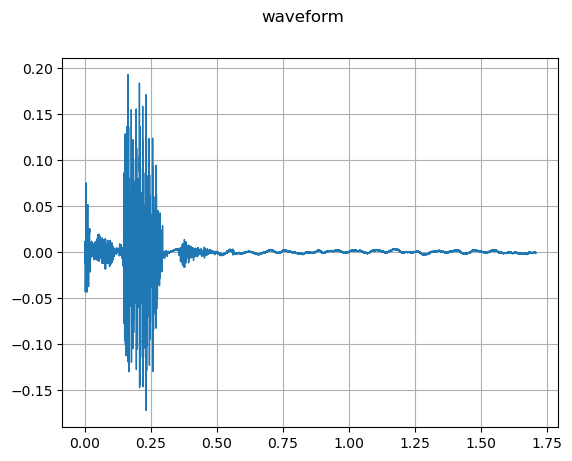

In [12]:
for waveform, sample_rate, speaker_id in vctk_train_dl:
    print(waveform.shape)
    break
plot_waveform(waveform[0], sample_rate[0])

# WaveNet Architecture

In [27]:
class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1):
        super().__init__()
        self.pad = (kernel_size - 1)*dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, dilation=dilation, padding=self.pad, bias=False)

    def forward(self, x):
        out = self.conv(x)
        out = out[:, :, :-self.pad] #we remove the extra element top of the tensor that could not be inferred
        return out

In [28]:
class GatedUnitBlock(nn.Module):
    def __init__(self, res_channels, skip_channels, kernel_size, dilation):
        super().__init__()
        self.sigma_conv = nn.Sequential(
            CausalConv1d(res_channels, res_channels, kernel_size, dilation=dilation),
            nn.Sigmoid()
        )
        self.tan_conv = nn.Sequential(
            CausalConv1d(res_channels, res_channels, kernel_size, dilation=dilation),
            nn.Tanh()
        )
        self.res_out = nn.Conv1d(res_channels, res_channels, 1)
        self.skip_conv = nn.Conv1d(res_channels, skip_channels, 1)


    def forward(self, x):
        sigma = self.sigma_conv(x)
        tan = self.tan_conv(x)
        out = sigma * tan
        res_out = self.res_out(out) + x
        skip_out = self.skip_conv(out)
        return res_out, skip_out

In [29]:
class WaveNetBlock(nn.Module):
    def __init__(self, in_channels, res_channels, skip_channels, kernel_size, ndilations):
        super().__init__()
        self.start_conv = nn.Sequential(*[
            nn.Conv1d(in_channels, res_channels, 1),
            nn.ReLU()
        ])
        self.blocks = nn.ModuleList([GatedUnitBlock(res_channels, skip_channels, kernel_size, 2**i) for i in range(ndilations)])

    def forward(self, x):
        out = self.start_conv(x)
        skip_connections = 0
        for block in self.blocks:
            res_out, skip_out = block(out)
            skip_connections = skip_connections + skip_out
            out = res_out
        out = F.relu(out)
        return out, skip_connections

In [30]:
class WaveNet(nn.Module):
    def __init__(self, nblocks=4, ndilations=4, in_channels=1, start_ch=64, skip_channels=512, nclasses=64, kernel_size=2):
        super().__init__()
        self.name = "WaveNet " + "nblocks=" + str(nblocks) + " ndilations=" + str(ndilations)
        channels = [in_channels] + [start_ch*(2**i) for i in range(nblocks)]
        self.wave_blocks = nn.ModuleList([
            WaveNetBlock(channels[i], channels[i+1], skip_channels, kernel_size, ndilations) for i in range(len(channels)-1)
        ])
        self.out_layers = nn.Sequential(
            nn.Conv1d(skip_channels, nclasses, 1),
            nn.ReLU(),
            nn.Conv1d(nclasses, nclasses, 1)
        )

    def forward(self, x):
        out = x
        skip_connections = 0
        for block in self.wave_blocks:
            res_out, skip_out = block(out)
            skip_connections = skip_connections + skip_out
            out = res_out
        out = F.relu(skip_connections)
        out = self.out_layers(out)
        return out

    def generate(self, n):
        with torch.no_grad():
            self.eval()
            x = torch.zeros(1, 1, 1).to(get_device())
            for _ in range(n):
                logits = self(x)
                probs = F.softmax(logits, dim=1)
                sample = probs[0, :, -1].multinomial(1)
                x = torch.cat([x, sample.unsqueeze(0).unsqueeze(0)], dim=2)
            return x[:, :, 1:]

# VQ-VAE Architecture

In [31]:
class ResBlock(nn.Module):
    def __init__(self, channels, kernel_size):
        super().__init__()
        self.block = nn.Sequential(*[
            nn.Conv1d(channels, channels, kernel_size, padding="same", bias=False),
            nn.BatchNorm1d(channels),
            nn.Tanh(),
            nn.Conv1d(channels, channels, kernel_size, padding="same", bias=False),
            nn.BatchNorm1d(channels),
        ])

    def forward(self, x):
        out = self.block(x)
        out = out + x
        return F.tanh(out)

In [32]:
class ConvEncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, res_blocks, kernel_size):
        super().__init__()
        self.in_block = nn.Sequential(*[
            nn.Conv1d(in_channels, out_channels, kernel_size, stride=2, padding=1, bias=False),
            nn.BatchNorm1d(out_channels),
            nn.Tanh()
        ])
        self.res_block = nn.Sequential(*[ResBlock(out_channels, kernel_size) for _ in range(res_blocks)])

    def forward(self, x):
        out = self.in_block(x)
        return self.res_block(out)

In [33]:
class Encoder(nn.Module):
    def __init__(self, hidden_dim, res_blocks, kernel_size=3):
        super().__init__()
        self.blocks = nn.Sequential(*[ConvEncoderBlock(hidden_dim[i], hidden_dim[i+1], res_blocks, kernel_size) for i in range(len(hidden_dim)-1)])

    def forward(self, x):
        out = self.blocks(x)
        return out

In [34]:
class VQ(nn.Module):
    #K=nemb=dimension of the discrete space (eq quantize each input, among one of K vectors)
    #D=emb_dim=dimension of each embedding vector
    def __init__(self, emb_dim=64, nemb=512, beta=0.25):
        super().__init__()
        self.emb_dim = emb_dim
        self.nemb = nemb
        self.beta = beta
        self.embedding = nn.Embedding(nemb, emb_dim)
        self.embedding.weight.data.uniform_(-1/nemb, 1/nemb)

    def forward(self, x): #x has shape B, C, T
        #We want to express the data as points of embedding dimension without taking into account batch and time dimension
        B, C, T = x.shape
        z_e = x.permute(0, 2, 1)
        z_e = z_e.reshape(B*T, self.emb_dim)
        #dist has shape B*T, nemb
        dist = torch.cdist(z_e, self.embedding.weight, p=2)
        #We want to find the closest embedding vector for each point
        min_idx = torch.argmin(dist, dim=1)
        min_one_hot = F.one_hot(min_idx, num_classes=self.nemb).float()
        e = min_one_hot @ self.embedding.weight

        #restore the original shape but now with the embedded points
        e = e.view(B, T, self.emb_dim).permute(0, 2, 1)
        vq_loss = F.mse_loss(x.detach(), e) + self.beta * F.mse_loss(x, e.detach())
        return e, vq_loss, min_idx.reshape(B,-1)

In [35]:
class ConvTransposeDecoder1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.conv = nn.ConvTranspose1d(in_channels, out_channels, kernel_size, stride=2, padding=1, bias=False)

    def forward(self, x):
        B,C,T = x.shape
        #to ensure the proper dimension and avoid ambiguity on the output shape of the transposed convolution
        out = self.conv(x, output_size=(B,int(C/2),T*2))
        return out

In [36]:
class TransposeConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, res_blocks, kernel_size):
        super().__init__()
        self.trans_block = nn.Sequential(*[
            ConvTransposeDecoder1d(in_channels, out_channels, kernel_size),
            nn.BatchNorm1d(out_channels),
            nn.Tanh()
        ])
        self.res_block = nn.Sequential(*[ResBlock(out_channels, kernel_size) for _ in range(res_blocks)])

    def forward(self, x):
        out = self.trans_block(x)
        return self.res_block(out)

In [37]:
class UpSampleBlock(nn.Module):
    def __init__(self, channels, kernel_size):
        super().__init__()
        self.up_block = nn.Sequential(*[
            ConvTransposeDecoder1d(channels, channels, kernel_size),
            nn.BatchNorm1d(channels),
            nn.Tanh()
        ])

    def forward(self, x):
        out = self.up_block(x)
        return out

In [38]:
class Decoder(nn.Module):
    def __init__(self, hidden_dim, ndilations, kernel_size=3):
        super().__init__()
        self.up_layers = nn.Sequential(*[UpSampleBlock(hidden_dim[0], kernel_size) for _ in range(len(hidden_dim)-1)])
        self.wave = nn.ModuleList([WaveNetBlock(hidden_dim[i], hidden_dim[i+1], 1, kernel_size, ndilations) for i in range(len(hidden_dim)-1)])

    def forward(self, x):
        out = self.up_layers(x)
        skip_connections = 0
        for block in self.wave:
            res_out, skip_out = block(out)
            skip_connections = skip_connections + skip_out
            out = res_out
        out = F.tanh(skip_connections)
        return out


In [39]:
class VQVAE(nn.Module):
    def __init__(self, in_channels=1, nemb=512, emb_dim=256, ndown=6, res_blocks=1, ndilations=6, kernel_size=3, beta = 0.25):
        super().__init__()
        self.name = "VQVAE" + " nemb=" + str(nemb) + " emb_dim=" + str(emb_dim) + " ndown=" + str(ndown) + " res=" + str(res_blocks) + " dil=" + str(ndilations)
        self.nemb = nemb
        self.emb_dim = emb_dim
        hidden_dim = [emb_dim//(2**i) for i in range(ndown)] + [in_channels]
        hidden_dim.reverse()

        self.encoder = Encoder(hidden_dim, res_blocks, kernel_size)
        self.vq = VQ(emb_dim, nemb, beta)
        hidden_dim.reverse()
        self.decoder = Decoder(hidden_dim, ndilations, kernel_size)


    def forward(self, x):
        z_e = self.encoder(x)
        z_q, vq_loss, _ = self.vq(z_e)
        #Add the connection between the input the decoder and the output of the encoder, to propagate the gradient
        z_q = z_e + (z_q - z_e).detach()
        x_hat = self.decoder(z_q)
        return x_hat, vq_loss

    def get_vq_indexes(self, x):
        z_e = self.encoder(x)
        _, _, min_idx = self.vq(z_e)
        return min_idx

    #given a latent code, it generates the corresponding waveform
    def generate(self, x):
        with torch.no_grad():
            self.eval()
            x_one_hot = F.one_hot(x, num_classes=self.nemb).float()
            e = x_one_hot @ self.vq.embedding.weight
            z_q = e.view(1, -1, self.emb_dim).permute(0, 2, 1)
            x_hat = self.decoder(z_q)
        return x_hat


# Training

In [25]:
device = get_device()
print(f"Using device: {device}")
model_vctk = VQVAE(in_channels=1, nemb=512, emb_dim=256, ndown=6, res_blocks=1, ndilations=8, kernel_size=3)
print(nparams(model_vctk))
#print(model_vctk)
opt_vctk = torch.optim.Adam(model_vctk.parameters(), lr=LEARNING_RATE, weight_decay=LEARNING_RATE/10)
trainer_vctk = Trainer(device, model_vctk, opt_vctk)

Using device: cuda
3242081


Epoch 1 -> Train Loss: 0.025152082190550675, Mean Absolute Error: 0.015903625637292862


Epoch 2 -> Train Loss: 0.004088566466729665, Mean Absolute Error: 0.012364556081593037


Epoch 3 -> Train Loss: 0.003985729058200791, Mean Absolute Error: 0.013626612722873688


Epoch 4 -> Train Loss: 0.004125048873463257, Mean Absolute Error: 0.014342899434268475


Epoch 5 -> Train Loss: 0.004062002790934881, Mean Absolute Error: 0.013533830642700195


Epoch 6 -> Train Loss: 0.0039951487986593735, Mean Absolute Error: 0.014996156096458435


Epoch 7 -> Train Loss: 0.004060916803217813, Mean Absolute Error: 0.01284018810838461


Epoch 8 -> Train Loss: 0.004060409745244944, Mean Absolute Error: 0.01406814157962799


Epoch 9 -> Train Loss: 0.003912214358319561, Mean Absolute Error: 0.013028323650360107


Epoch 10 -> Train Loss: 0.004035696668861492, Mean Absolute Error: 0.013379729352891445


Epoch 11 -> Train Loss: 0.003946873264810625, Mean Absolute Error: 0.014889459125697613


Epoch 12 -> Train Loss: 0.003979095542042759, Mean Absolute Error: 0.013986043632030487


Epoch 13 -> Train Loss: 0.004046259239853654, Mean Absolute Error: 0.012596497312188148


Epoch 14 -> Train Loss: 0.003937758583846189, Mean Absolute Error: 0.013299527578055859


Epoch 15 -> Train Loss: 0.003926656899591133, Mean Absolute Error: 0.014692681841552258


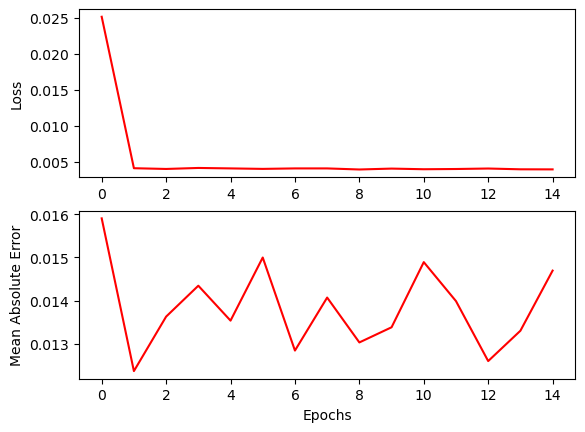

In [26]:
trainer_vctk.train(epochs=EPOCHS, dl_train=vctk_train_dl, check=1, save=True)

# Test on Validation Dataset

torch.Size([2, 1, 81920])
0.005654341075569391


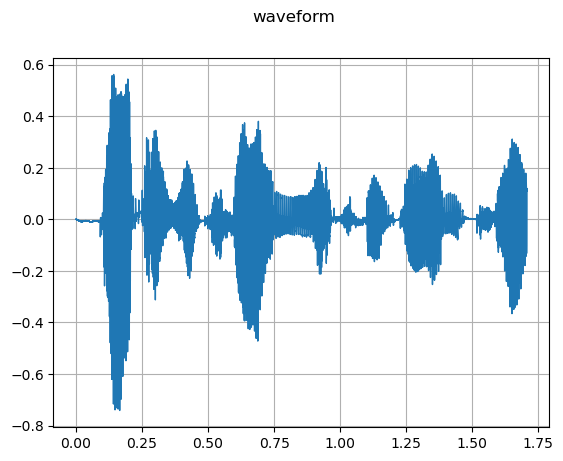

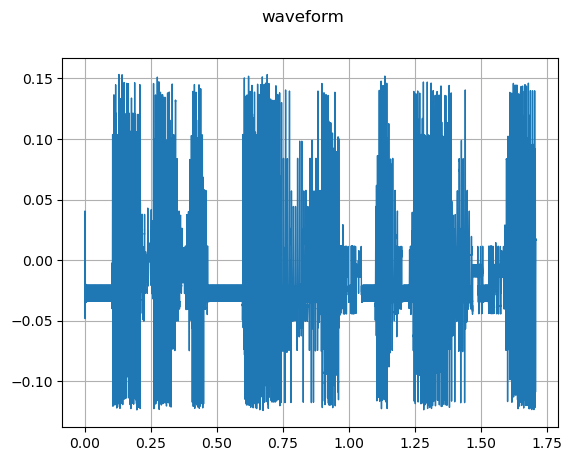

In [43]:
#Evaluate the model on the validation dataset
with torch.no_grad():
    for waveform, sample_rate, speaker_id in vctk_val_dl:
        print(waveform.shape)
        break
    plot_waveform(waveform[0], sample_rate[0])
    model_vctk.eval()
    logits, vq_loss = model_vctk(waveform[0].unsqueeze(0).float().to(device))
    print(F.mse_loss(logits, waveform[0].unsqueeze(0).float().to(device)).item())
    plot_waveform(logits[0].detach().cpu(), sample_rate[0])

In [29]:
audio_original = Audio(waveform[0].detach().cpu(), rate=sample_rate[0].item())
display(audio_original)

In [30]:
audio_reconstructed = Audio(logits[0].detach().cpu(), rate=sample_rate[0].item())
display(audio_reconstructed)

# Load Model

In [42]:
device = get_device()
print(f"Using device: {device}")
model_vctk = VQVAE(in_channels=1, nemb=512, emb_dim=256, ndown=6, res_blocks=1, ndilations=8, kernel_size=3)
opt_vctk = torch.optim.Adam(model_vctk.parameters(), lr=LEARNING_RATE, weight_decay=LEARNING_RATE/10)

model_string = model_vctk.name + ".pt"
path = "./models/" + model_string
trainer_vctk = Trainer(device, model_vctk, opt_vctk, path)
print(nparams(model_vctk))

Using device: cuda
3242081


In [30]:
save_results(model_vctk, vctk_val_dl, nfiles=100)

# Dataset of VQ Indexes

In [44]:
save_idx = False
load_idx = True
if load_idx:
    idx_dataset = torch.load("./models/index_dataset nemb=512 emb_dim=256.pt")
else:
    idx_dataset = trainer_vctk.get_index_dataset(vctk_train_dl)
if save_idx:
    torch.save(idx_dataset, "./models/index_dataset nemb=512 emb_dim=256.pt")
print(idx_dataset.shape)    

torch.Size([21936, 1280])


In [45]:
idx_dataset = idx_dataset.long()
counts = []
for _ in range(512):
    counts.append(0)
for i in range(idx_dataset.shape[0]):
    for j in range(idx_dataset.shape[1]):
        counts[idx_dataset[i][j]] += 1
zero_entries = 0
for i in range(len(counts)):
    if counts[i] == 0:
        zero_entries += 1
print(f"Codebook Dim: {len(counts)}, Zero Entries: {zero_entries}")

Codebook Dim: 512, Zero Entries: 479


In [46]:
dim = 0
split = 1

train_size = int(split * len(idx_dataset))
val_size = len(idx_dataset) - train_size
train_idx, val_idx = idx_dataset[:train_size], idx_dataset[train_size:]
train_dl_idx = DataLoader(TensorDataset(train_idx[:, :-1].unsqueeze(1), train_idx[:, 1:]), batch_size=8)
if split < 1:
    val_dl_idx = DataLoader(TensorDataset(val_idx[:, :-1].unsqueeze(1), val_idx[:, 1:]), batch_size=8)
for _, (idx_src,idx_tgt) in enumerate(train_dl_idx):
    print(idx_src.shape, idx_tgt.shape)
    break

torch.Size([8, 1, 1279]) torch.Size([8, 1279])


# WaveNet Training

In [47]:
class WaveTrainer:
    def __init__(self, device, model, opt, path=None):
        self.device = device
        self.model = model
        self.model.to(self.device)
        self.opt = opt
        self.loss_train = []
        self.loss_test = []
        self.epochs = 0
        self.acc_train = []
        if path:
            self.model.load_state_dict(torch.load(path))
            
    def train(self, epochs, dl_train, dl_test=None, check=100, save=False):
        self.model.train()
        self.loss_train = []
        self.loss_test = []
        self.acc_train = []
        for i in range(self.epochs+1,self.epochs+epochs+1):
            avg_loss_train, train_acc = self._train_epoch_(dl_train, i)
            self.loss_train.append(avg_loss_train)
            self.acc_train.append(train_acc.item())
            if i%check==0 and i !=0:
                print(f"Epoch {i} -> Train Loss: {avg_loss_train} Train Acc: {train_acc}")
                if save:
                    model_string = self.model.name + ".pt"
                    path = "./models/" + model_string
                    torch.save(self.model.state_dict(), path)
                if dl_test:
                    avg_loss_test, test_acc = self._test_epoch_(dl_test, i)
                    print(f"Test Loss: {avg_loss_test}, Test Acc: {test_acc}")
            self.epochs += 1
        self._plot_()
    
    def _train_epoch_(self, dl_train, epoch):
        epoch_loss = 0
        for x, y in tqdm(dl_train, desc=f'Training epoch {epoch}', leave = False):
            x = x.float().to(self.device)
            y = y.long().to(self.device)
            logits = self.model(x)
            total_loss = nn.CrossEntropyLoss()(logits, y)

            self.opt.zero_grad()
            total_loss.backward()
            self.opt.step()
            epoch_loss += total_loss.item()
        return epoch_loss / len(dl_train), self.compute_accuracy(logits, y)
    
    def _test_epoch_(self, dl_test, epoch):
        with torch.no_grad():
            epoch_loss = 0
            for x, y in tqdm(dl_test, desc=f'Testing epoch {epoch}', leave = False):
                x = x.to(self.device)
                y = y.long().to(self.device)
                logits = self.model(x)
                total_loss = nn.CrossEntropyLoss()(logits, y)
                epoch_loss += total_loss.item()
            return epoch_loss / len(dl_test), self.compute_accuracy(logits, y)
        
    def compute_accuracy(self, logits, y):
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        acc = torch.mean((preds == y).float())
        return acc


    def _plot_(self):
        fig, (ls, ac) = plt.subplots(2)

        ls.plot(self.loss_train, label="Train", color="red")
        ls.set_xlabel("Epochs")
        ls.set_ylabel("Loss")

        ac.plot(self.acc_train, label="Train", color="red")
        ac.set_xlabel("Epochs")
        ac.set_ylabel("Accuracy")

In [54]:
device = get_device()
wave_vctk = WaveNet(nblocks=4, ndilations=8, in_channels=1, start_ch=32, skip_channels=512, nclasses=512, kernel_size=2)
print(nparams(wave_vctk))
#print(wave_vctk)
wave_opt = torch.optim.Adam(wave_vctk.parameters(), lr=1e-3, weight_decay=1e-4)
trainer_wave = WaveTrainer(device, wave_vctk, wave_opt)

6036736


Training epoch 1:   0%|          | 0/2742 [00:00<?, ?it/s]

Epoch 1 -> Train Loss: 0.8182342880555611 Train Acc: 0.8092259764671326


Epoch 2 -> Train Loss: 0.6509764938894456 Train Acc: 0.8150899410247803


Epoch 3 -> Train Loss: 0.7451012651473392 Train Acc: 0.8158717751502991


Epoch 4 -> Train Loss: 0.6484753784365588 Train Acc: 0.8166536688804626


Epoch 5 -> Train Loss: 0.6339222426770118 Train Acc: 0.8147967457771301


Epoch 6 -> Train Loss: 0.6341018837507757 Train Acc: 0.8136239647865295


Epoch 7 -> Train Loss: 0.6236114180670612 Train Acc: 0.8216379880905151


Epoch 8 -> Train Loss: 0.6238955348773563 Train Acc: 0.8211493492126465


Epoch 9 -> Train Loss: 0.6175743789350264 Train Acc: 0.8149921894073486


Epoch 10 -> Train Loss: 0.6192185173910261 Train Acc: 0.8228108286857605


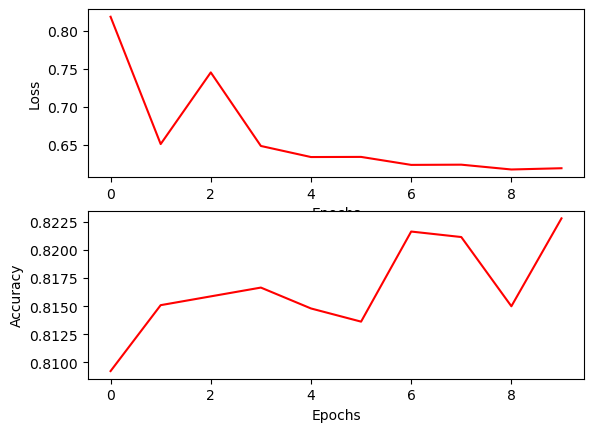

In [55]:
trainer_wave.train(epochs=10, dl_train=train_dl_idx, check=1, save=True)

# WaveNet Load Model

In [48]:
device = get_device()
print(f"Using device: {device}")
wave_vctk = WaveNet(nblocks=4, ndilations=4, in_channels=1, start_ch=16, skip_channels=256, nclasses=512, kernel_size=2)
wave_opt = torch.optim.Adam(wave_vctk.parameters(), lr=1e-3, weight_decay=1e-4)


model_string = wave_vctk.name + ".pt"
path = "./models/" + model_string
trainer_wave = WaveTrainer(device, wave_vctk, wave_opt, path)

Using device: cuda


In [53]:
for _, (idx_src,idx_tgt) in enumerate(train_dl_idx):
    print(idx_src.shape, idx_tgt.shape)
    break
logits = wave_vctk(idx_src.to(device).float())
print(logits.shape)
probs = F.softmax(logits, dim=1)
print(probs.shape)
preds = torch.argmax(probs, dim=1)
print(preds.shape)
print(preds[0, :10])
print(idx_tgt[0, :10])
print(torch.sum(preds[0]==idx_tgt.to(device)[0])/len(idx_tgt[0]))

torch.Size([8, 1, 1279]) torch.Size([8, 1279])
torch.Size([8, 512, 1279])
torch.Size([8, 512, 1279])
torch.Size([8, 1279])
tensor([29, 29, 29, 29, 29, 29, 29, 17, 17, 29], device='cuda:0')
tensor([29, 29, 29, 29, 29, 29, 17, 17, 29, 17])
tensor(0.8522, device='cuda:0')


# Sample Generation

In [64]:
length = 1500
gen = wave_vctk.generate(length)
audio_gen = model_vctk.generate(gen.long())

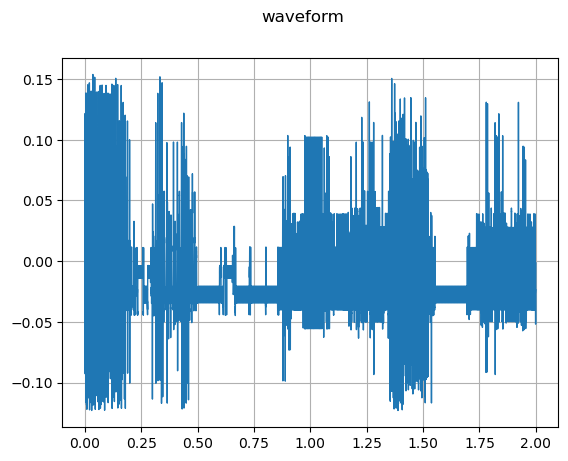

In [65]:
plot_waveform(audio_gen[0].detach().cpu(), sample_rate[0])

In [66]:
prova_audio = Audio(audio_gen[0].detach().cpu(), rate=sample_rate[0].item())
display(prova_audio)

In [68]:
save_samples = False
nsamples = 10
for i in range(nsamples):
    gen = wave_vctk.generate(1500)
    audio_gen = model_vctk.generate(gen.long())

    if save_samples:
        plot_waveform(audio_gen[0].detach().cpu(), sample_rate=sample_rate[0].item())
        plt.savefig("generated/ndilations8/" + str(i) + ".png")
        plt.close()

        torchaudio.save("generated/ndilations8/" + str(i) + ".wav", audio_gen[0].detach().cpu(), sample_rate[0].item())